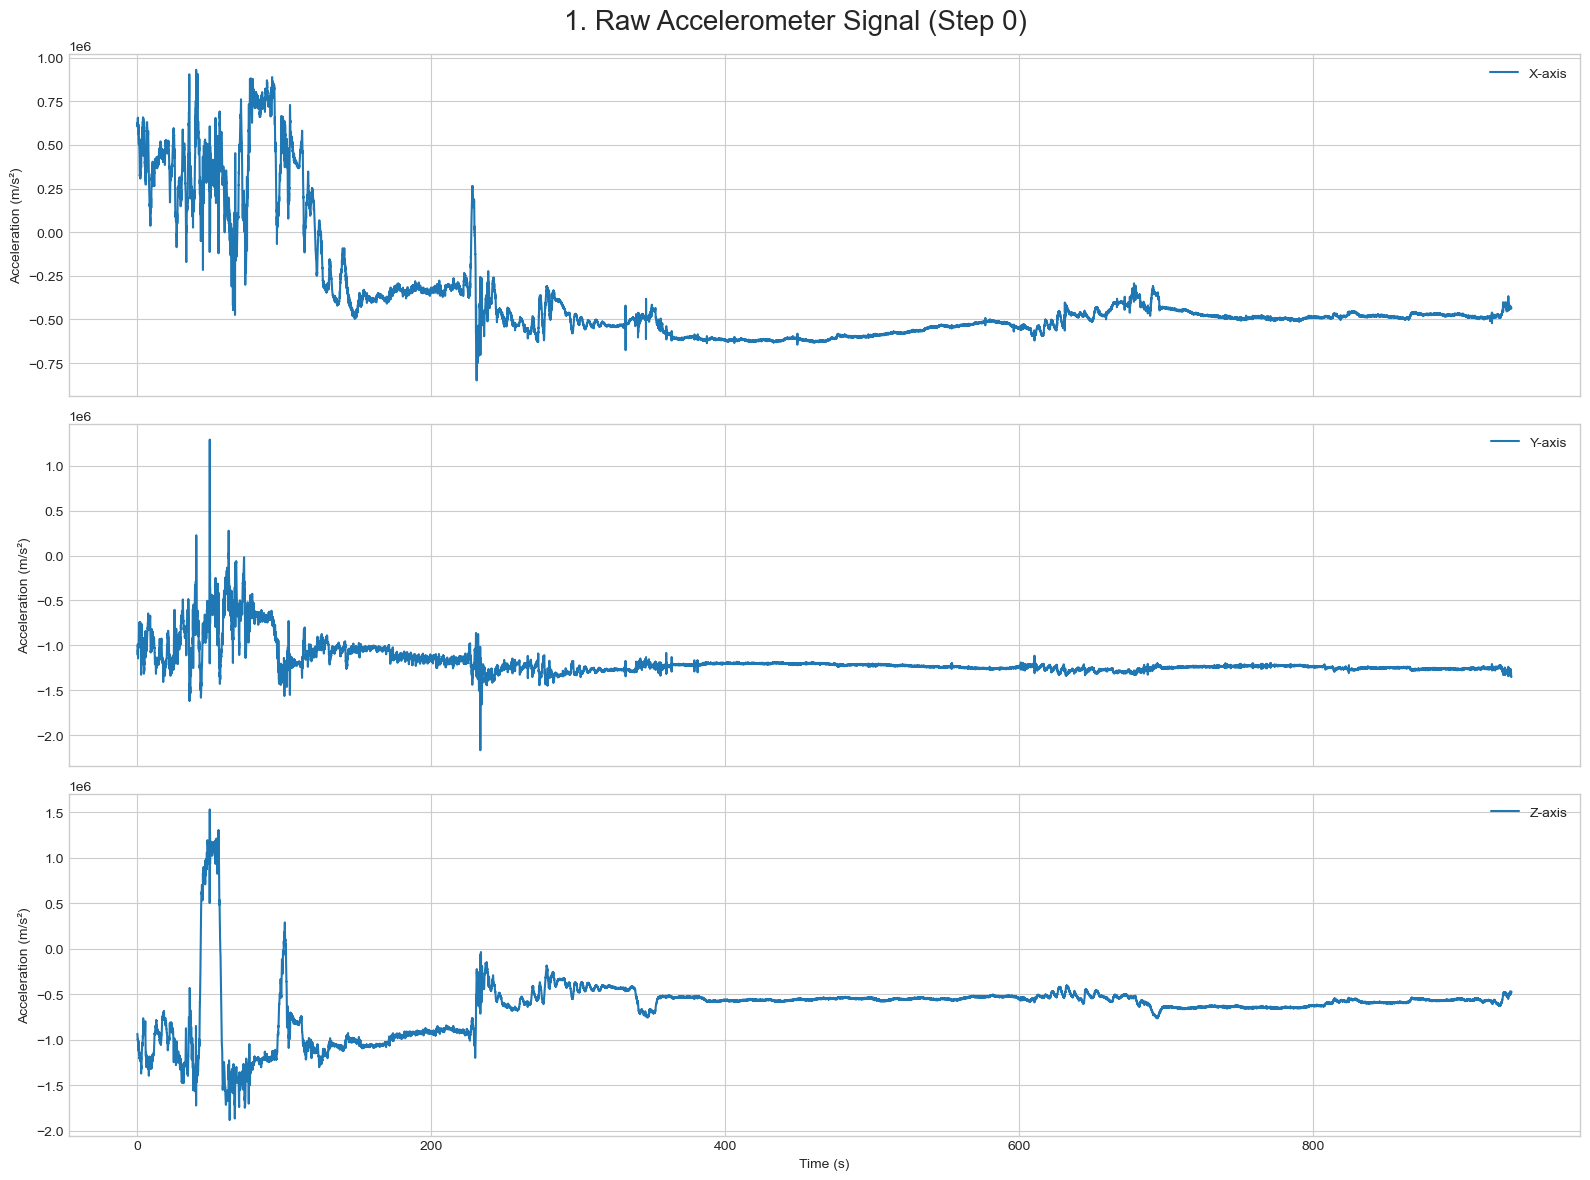

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from pathlib import Path

# Fix module path for imports
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Imports
from src.accelerometer._02_preprocess import AccelerometerPreprocessor
from src.accelerometer.config import *
from src.accelerometer._01_get_data import DataLoader, MultiDataLoader

# Matplotlib settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['figure.dpi'] = 100

# Load a single PD patient file (OFF medication)
file_path = DATA_DIR / "801_1_accelerometer.pkl"
preprocessor = AccelerometerPreprocessor([file_path], sampling_freq=SAMPLING_FREQ)

# Get the initial raw data
raw_data = preprocessor.multi_data[0]
fs = SAMPLING_FREQ
timesteps = np.arange(raw_data.shape[1]) / fs

# Plot the Raw Signal
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(16, 12))
fig.suptitle("1. Raw Accelerometer Signal (Step 0)", fontsize=20)
for i, axis_label in enumerate(['X', 'Y', 'Z']):
    ax[i].plot(timesteps, raw_data[i], label=f'{axis_label}-axis')
    ax[i].set_ylabel(f'Acceleration (m/s²)')
    ax[i].legend()
ax[-1].set_xlabel('Time (s)')
plt.tight_layout()
plt.show()

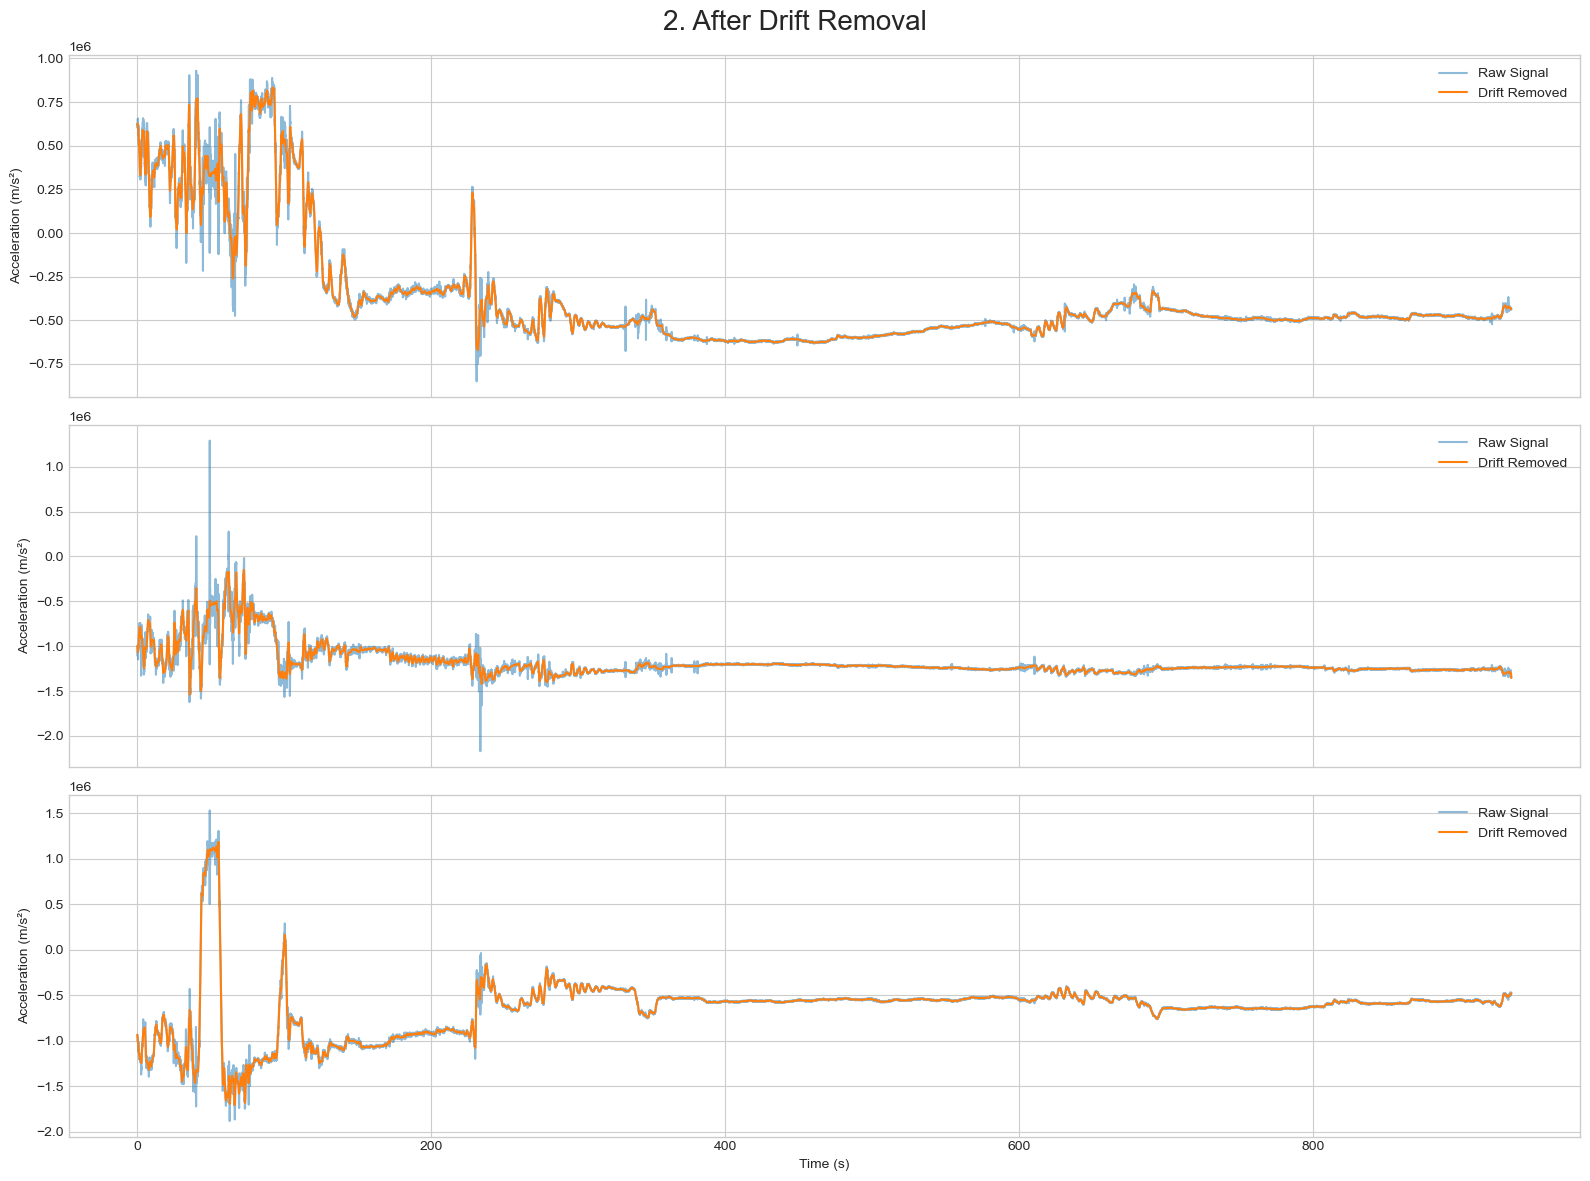

In [2]:
# Run the drift removal step
preprocessor._remove_drift(window_size=DRIFT_WINDOW_SIZE)
drift_removed_data = preprocessor.multi_data[0]

# Plot Filtered vs Raw
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(16, 12))
fig.suptitle("2. After Drift Removal", fontsize=20)
for i, axis_label in enumerate(['X', 'Y', 'Z']):
    ax[i].plot(timesteps, raw_data[i], label='Raw Signal', alpha=0.5)
    ax[i].plot(timesteps, drift_removed_data[i], label='Drift Removed')
    ax[i].set_ylabel(f'Acceleration (m/s²)')
    ax[i].legend()
ax[-1].set_xlabel('Time (s)')
plt.tight_layout()
plt.show()

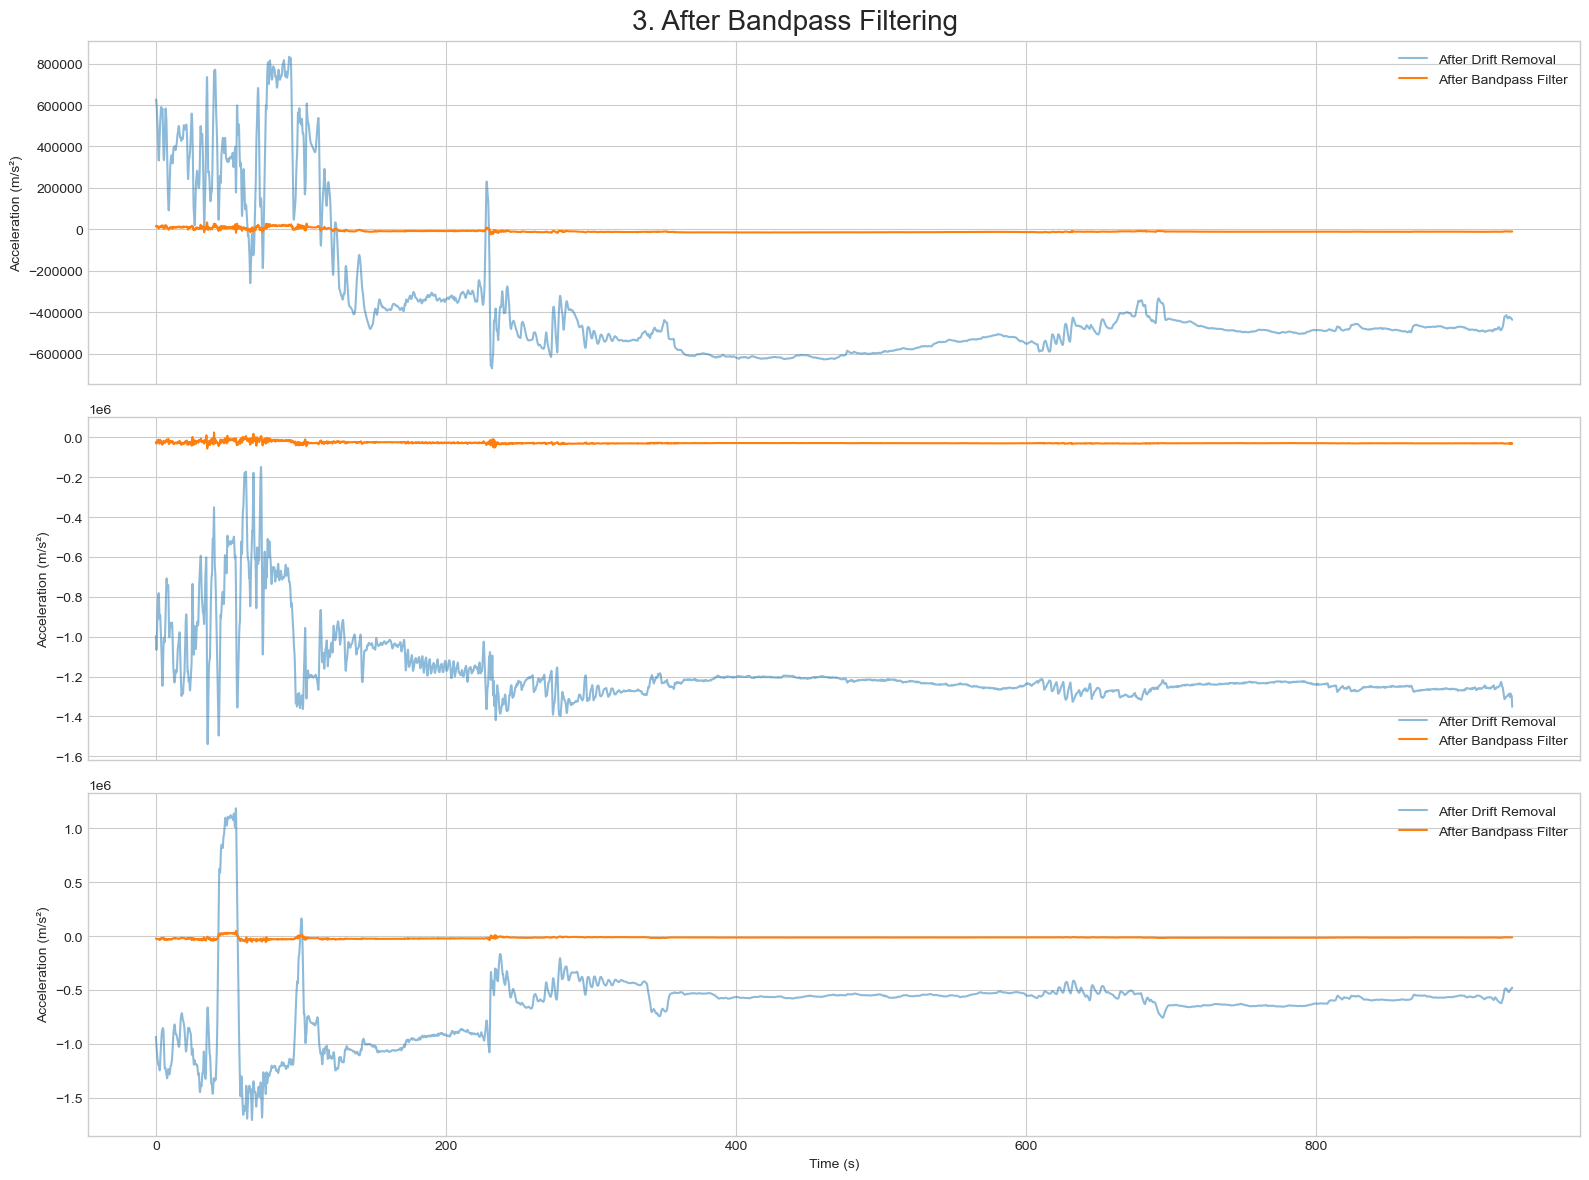

In [3]:
# Run the bandpass filtering step
preprocessor._bandpass_filter(lowcut=BANDPASS_LOWCUT, highcut=BANDPASS_HIGHCUT, freq_resolution=BANDPASS_FREQ_RESOLUTION)
filtered_data = preprocessor.multi_data[0]

# Plot against previous step
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(16, 12))
fig.suptitle("3. After Bandpass Filtering", fontsize=20)
for i, axis_label in enumerate(['X', 'Y', 'Z']):
    ax[i].plot(timesteps, drift_removed_data[i], label='After Drift Removal', alpha=0.5)
    ax[i].plot(timesteps, filtered_data[i], label='After Bandpass Filter')
    ax[i].set_ylabel(f'Acceleration (m/s²)')
    ax[i].legend()
ax[-1].set_xlabel('Time (s)')
plt.tight_layout()
plt.show()

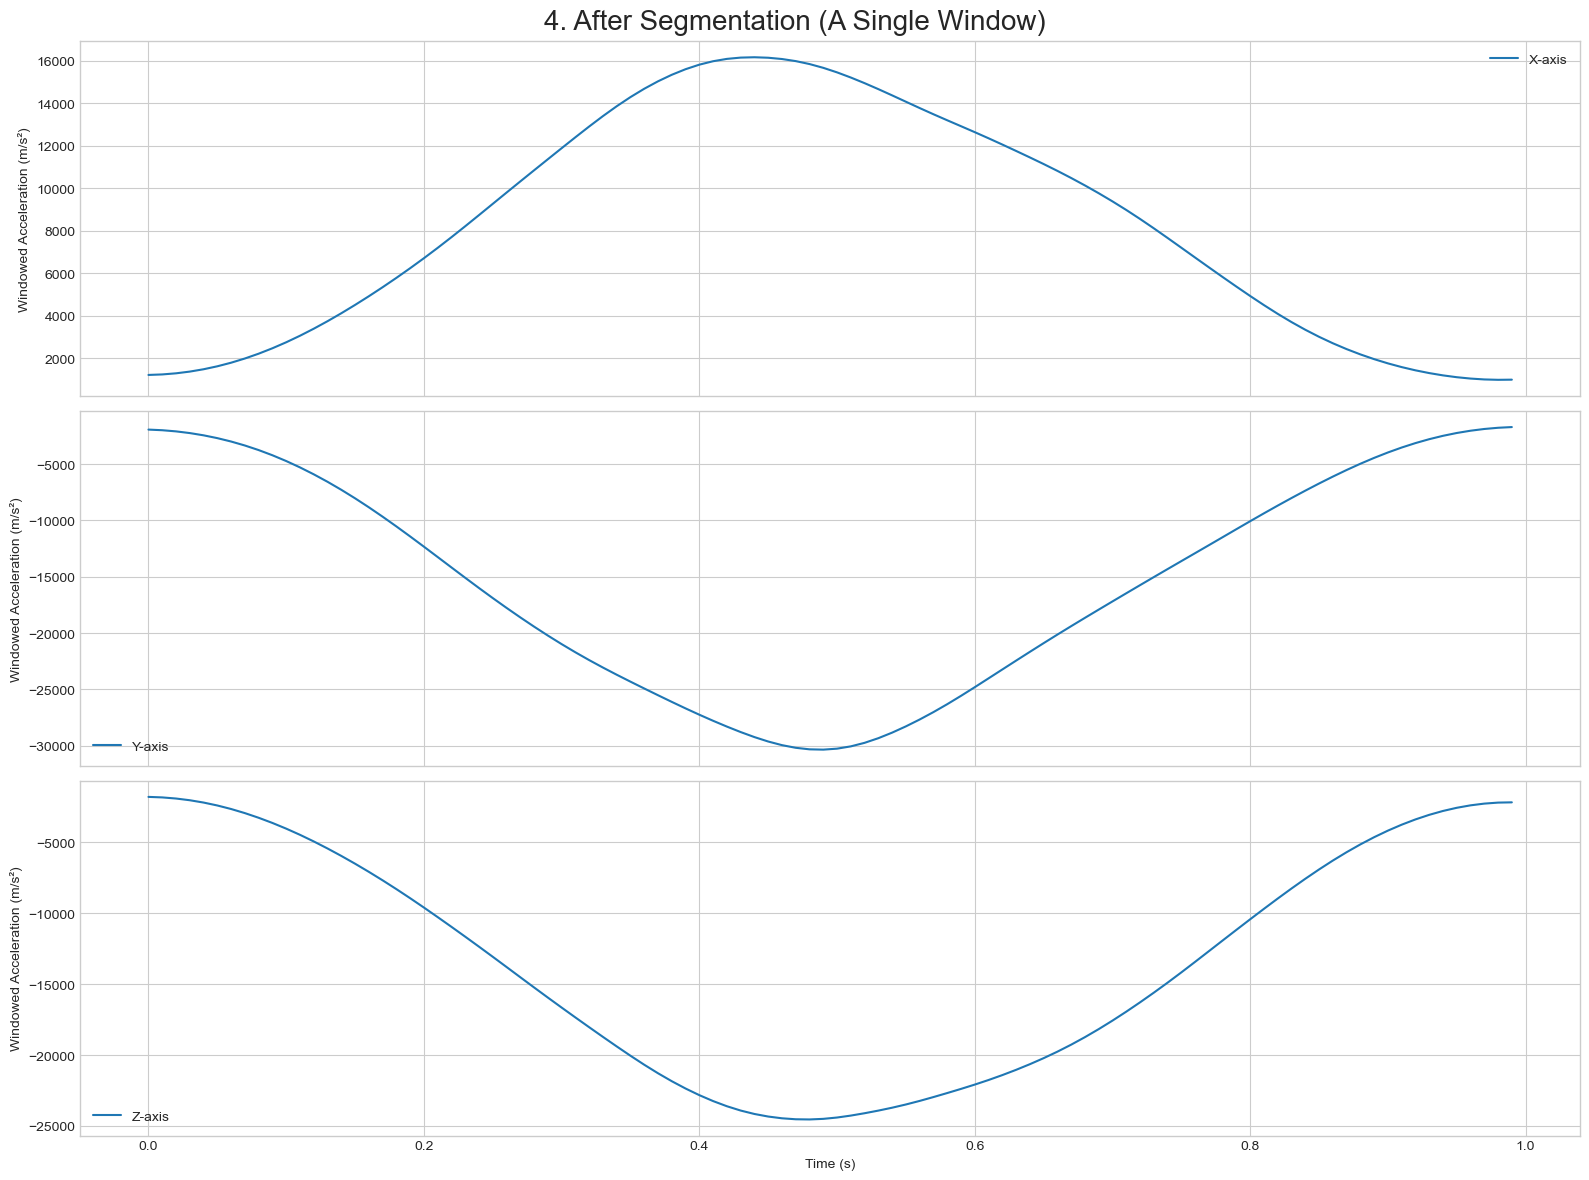

In [4]:
# Run the segmentation step
preprocessor._segment_data(window_size=SEGMENT_WINDOW_SIZE, percent_overlap=SEGMENT_PERCENT_OVERLAP)
segmented_data = preprocessor.multi_data[0]

# Plot a single window
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(16, 12))
fig.suptitle("4. After Segmentation (A Single Window)", fontsize=20)

# We plot the first window from the segmented data
window_to_plot = 0
window_data = segmented_data[:, window_to_plot, :]
window_timesteps = np.arange(window_data.shape[1]) / fs

for i, axis_label in enumerate(['X', 'Y', 'Z']):
    ax[i].plot(window_timesteps, window_data[i], label=f'{axis_label}-axis')
    ax[i].set_ylabel(f'Windowed Acceleration (m/s²)')
    ax[i].legend()
ax[-1].set_xlabel('Time (s)')
plt.tight_layout()
plt.show()

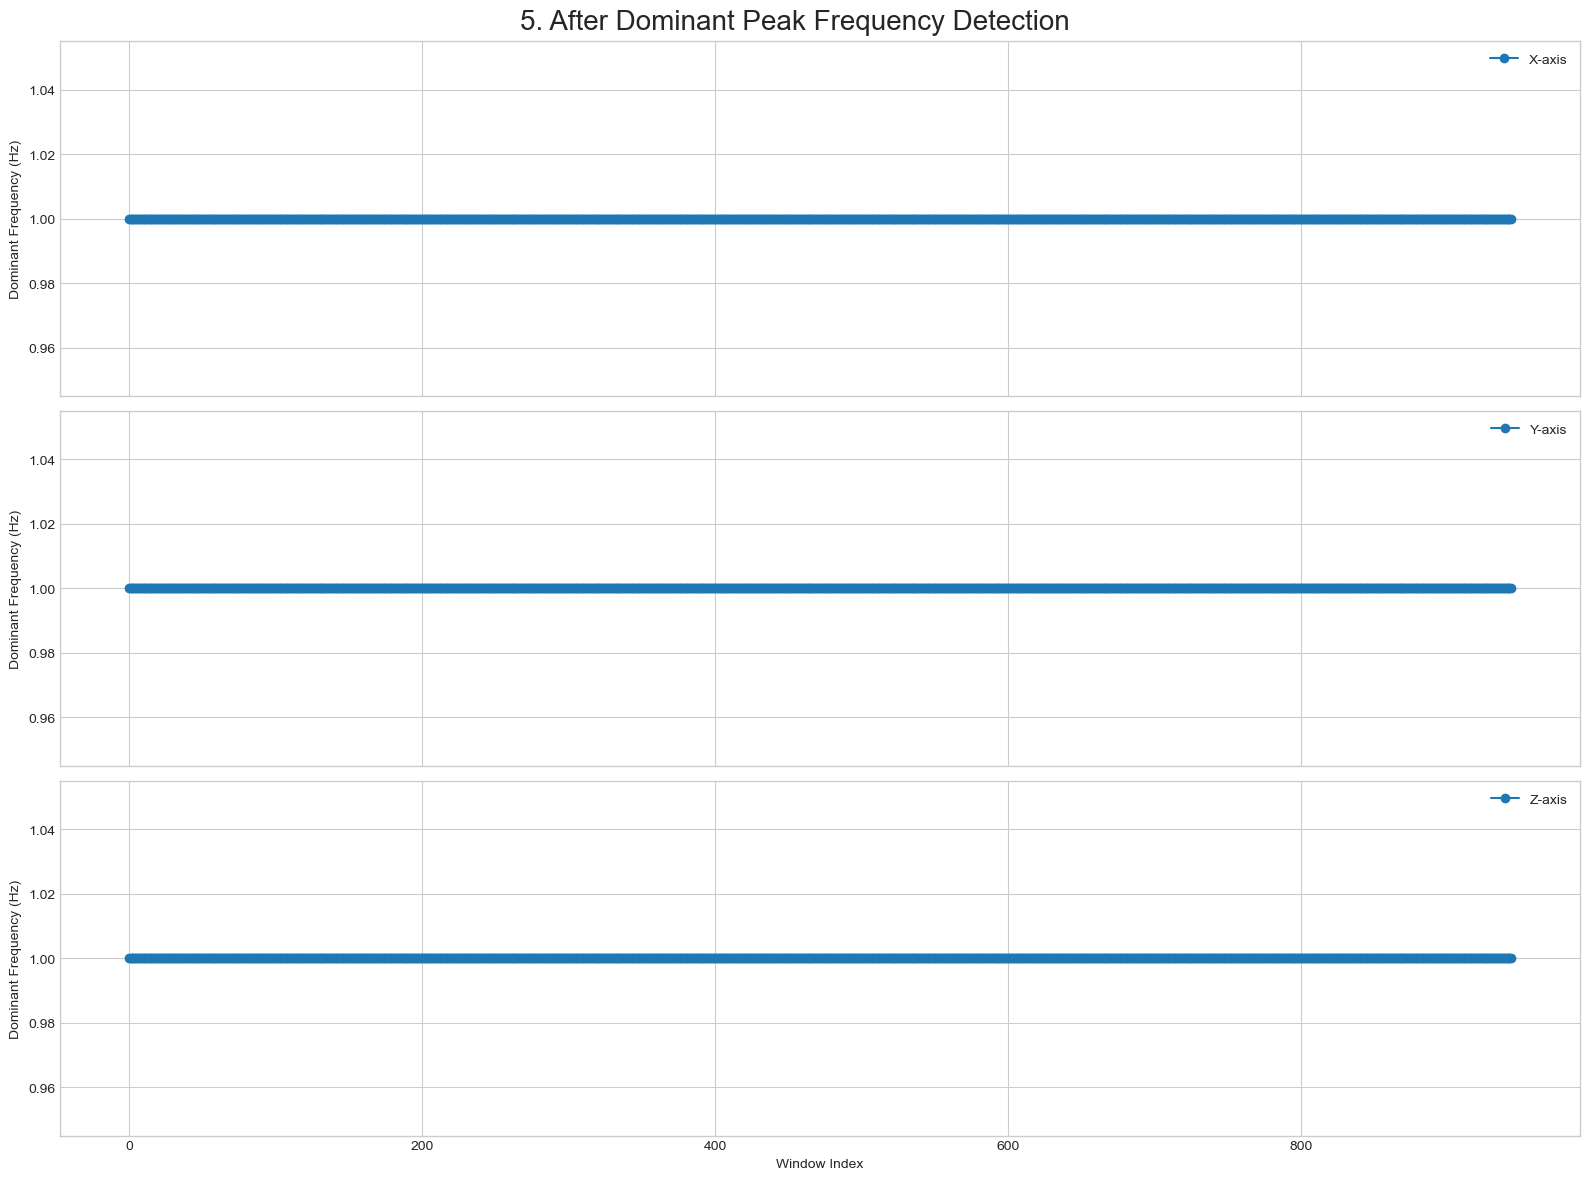

In [5]:
# Run the feature extraction step
preprocessor._detect_peak_frequency(
    low_freq=PEAK_LOW_FREQ, high_freq=PEAK_HIGH_FREQ, ar_order=AR_ORDER, 
    prominence_percent=PROMINENCE_PERCENT
)
peak_frequencies = preprocessor.multi_data[0]

# The data is now a list of dominant frequencies
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(16, 12))
fig.suptitle("5. After Dominant Peak Frequency Detection", fontsize=20)
for i, axis_label in enumerate(['X', 'Y', 'Z']):
    ax[i].plot(peak_frequencies[i], 'o-', label=f'{axis_label}-axis')
    ax[i].set_ylabel('Dominant Frequency (Hz)')
    ax[i].legend()
ax[-1].set_xlabel('Window Index')
plt.tight_layout()
plt.show()

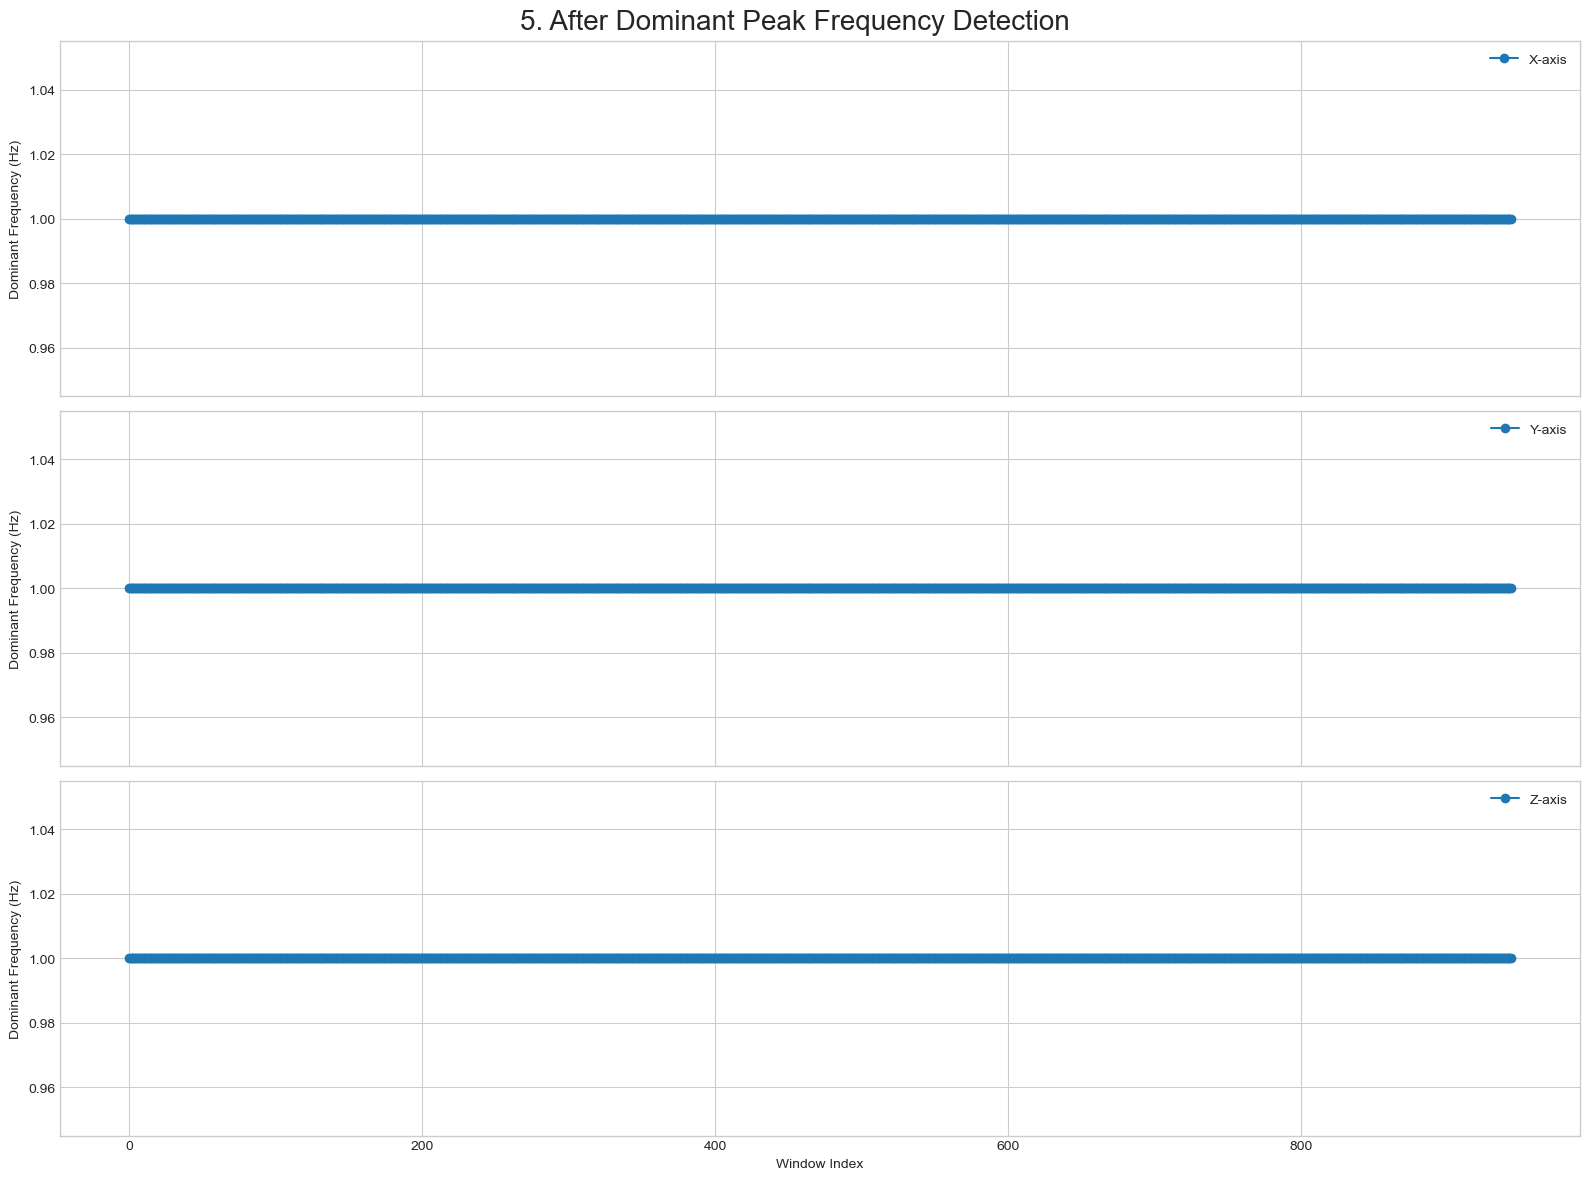

In [6]:
# Run the feature extraction step
preprocessor._detect_peak_frequency(
    low_freq=PEAK_LOW_FREQ, high_freq=PEAK_HIGH_FREQ, ar_order=AR_ORDER, 
    prominence_percent=PROMINENCE_PERCENT
)
peak_frequencies = preprocessor.multi_data[0]

# The data is now a list of dominant frequencies
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(16, 12))
fig.suptitle("5. After Dominant Peak Frequency Detection", fontsize=20)
for i, axis_label in enumerate(['X', 'Y', 'Z']):
    ax[i].plot(peak_frequencies[i], 'o-', label=f'{axis_label}-axis')
    ax[i].set_ylabel('Dominant Frequency (Hz)')
    ax[i].legend()
ax[-1].set_xlabel('Window Index')
plt.tight_layout()
plt.show()

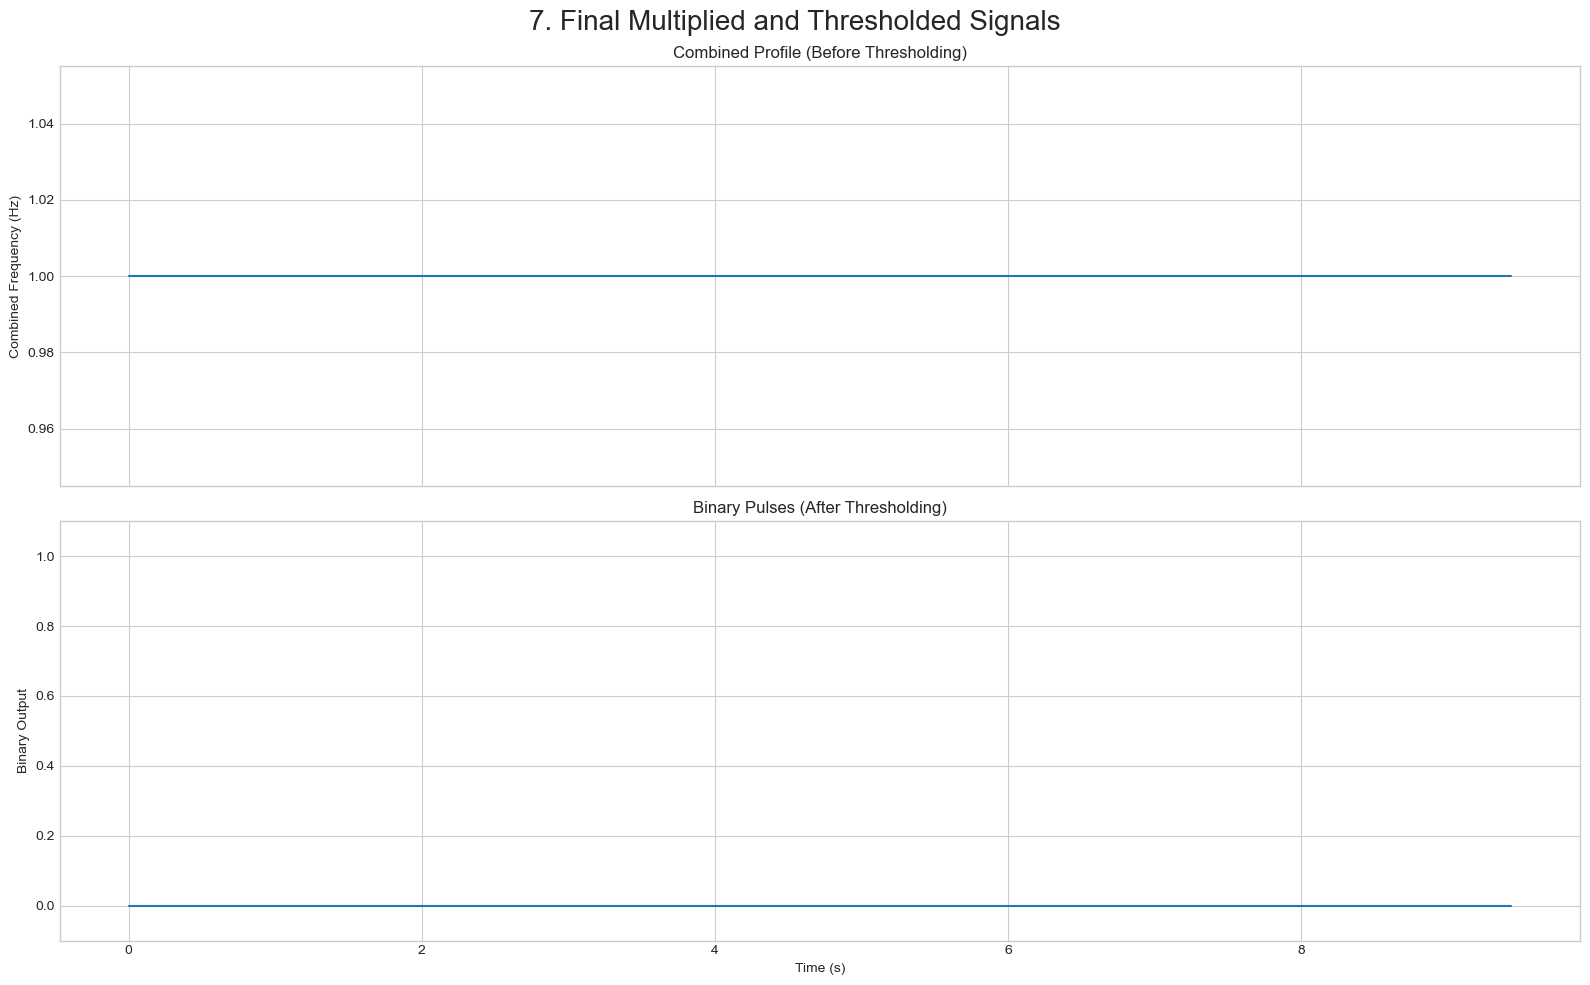

In [7]:
# Run the final steps
preprocessor._multiply()
multiplied_data = preprocessor.multi_data[0]

preprocessor._thresholding(threshold=FEATURE_THRESHOLD)
binary_data = preprocessor.multi_data[0]

# Plot the final output
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(16, 10))
fig.suptitle("7. Final Multiplied and Thresholded Signals", fontsize=20)

upsampled_timesteps = np.arange(multiplied_data.shape[0]) / fs
ax[0].plot(upsampled_timesteps, multiplied_data)
ax[0].set_ylabel('Combined Frequency (Hz)')
ax[0].set_title('Combined Profile (Before Thresholding)')

ax[1].plot(upsampled_timesteps, binary_data)
ax[1].set_ylabel('Binary Output')
ax[1].set_xlabel('Time (s)')
ax[1].set_title('Binary Pulses (After Thresholding)')
ax[1].set_ylim(-0.1, 1.1)

plt.tight_layout()
plt.show()